In [1]:
## Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

# TensorFlow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall, AUC

In [2]:
## Loading data
df = pd.read_csv("defaut_de_paiment.csv")
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
## Data preprocessing

# Unused columns
df = df.drop(columns = ["ID", "year"], errors = "ignore")

# Fill empty cells
df = df.ffill()

# Encoding categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include = 'object').columns:
    df[col] = le.fit_transform(df[col])

# Data normalization
x = df.drop("Status", axis = 1)
y = df["Status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size = 0.2, 
    random_state = 42
)

# Recalculate class weights
weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

# Put in dictionary form
class_weights = {0: weights[0], 1: weights[1]}
print("Classes weights : ", class_weights)


Classes weights :  {0: 0.6641723533287914, 1: 2.0227898908126125}


In [4]:
## Model construction 
model = Sequential([
    Input(shape = (X_train.shape[1],)),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(16, activation = 'relu'),
    Dense(8, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(
    optimizer = 'adam', 
    loss = 'binary_crossentropy', 
    metrics = [
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC()
    ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,105 (59.00 KB)

 Trainable params: 15,105 (59.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
## Model training
history = model.fit(
    X_train, 
    y_train, 
    epochs = 50, 
    batch_size = 32, 
    validation_split = 0.2,
    class_weight = class_weights
)

Epoch 1/50
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.7553 - auc: 0.8333 - loss: 0.4901 - precision: 0.5211 - recall: 0.7467 - val_accuracy: 0.7525 - val_auc: 0.5000 - val_loss: 0.6643 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.5162 - auc: 0.5006 - loss: 0.6916 - precision: 0.2366 - recall: 0.4677 - val_accuracy: 0.2475 - val_auc: 0.5000 - val_loss: 0.6936 - val_precision: 0.2475 - val_recall: 1.0000
Epoch 3/50
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.4829 - auc: 0.4961 - loss: 0.6944 - precision: 0.2445 - recall: 0.5289 - val_accuracy: 0.2475 - val_auc: 0.5000 - val_loss: 0.6985 - val_precision: 0.2475 - val_recall: 1.0000
Epoch 4/50
2974/2974 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.4150 - auc: 0.4976 - loss: 0.6959 - precision: 0.2487 - recall: 0.6639 - val_accuracy: 0.2475 - val_auc: 0.5000 - val_loss: 0.6964 - val_precision: 0.2475 - val_recall: 1.0000
Epoch 5/50
2

930/930 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Predicted classes distribution :  (array([1]), array([29734], dtype=int64))
Classification report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22494
           1       0.24      1.00      0.39      7240

    accuracy                           0.24     29734
   macro avg       0.12      0.50      0.20     29734
weighted avg       0.06      0.24      0.10     29734



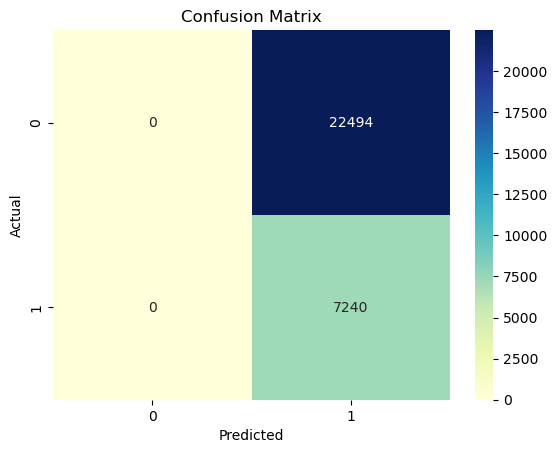

In [6]:
## Model evaluation
# Predictions
y_proba = model.predict(X_test)
y_pred = (y_proba > 0.2).astype("int32")

# Inbalance in predictions
print("Predicted classes distribution : ", np.unique(y_pred, return_counts = True))

# Classification report
print("Classification report : ")
print(classification_report(y_test, y_pred, zero_division = 0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt='d', cmap = "YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

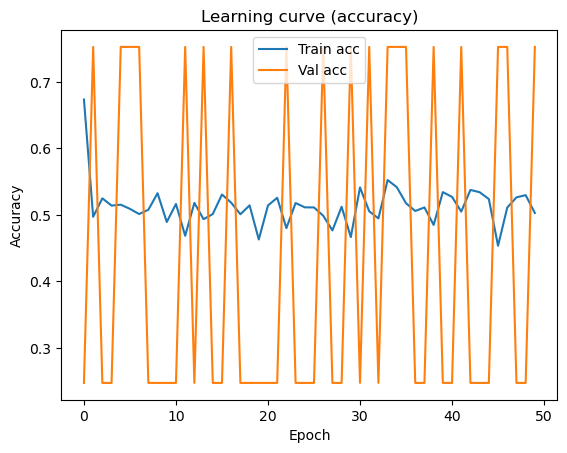

In [7]:
## Learning curves
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning curve (accuracy)')
plt.show()